In [38]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("data/training_dataset.csv",sep=";")
df.head()

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0


Data Exploration

In [36]:
print(df.isna().sum())
print(df["Date"].nunique())
print(df["PORTAL"].unique())
nuls_per_columns = (df == 0).sum()
print(nuls_per_columns)
lines_per_sensor = df['PORTAL'].value_counts()
print(lines_per_sensor)
print(df.groupby('PORTAL')['DP_ID'].unique())

DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            62
dtype: int64
214
['E4S 56,780' 'E4S 56,160' 'E4S 56,490' 'E4S 57,055' 'E4S 57,435'
 'E4S 57,820' 'E4S 58,140' 'E4S 55,620']
DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    2
FLOW            0
dtype: int64
PORTAL
E4S 58,140    293742
E4S 56,780    272954
E4S 56,490    263024
E4S 57,820    239228
E4S 57,055    218102
E4S 55,620    217095
E4S 56,160    217055
E4S 57,435    200767
Name: count, dtype: int64
PORTAL
E4S 55,620                 [751, 1254, 1076]
E4S 56,160                   [539, 536, 740]
E4S 56,490             [351, 4873, 153, 902]
E4S 56,780            [543, 534, 4872, 1079]
E4S 57,055                  [353, 1443, 749]
E4S 57,435             

In [116]:
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])
df['Time_dt'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['Date_dt'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')
df.head()

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Datetime,Time_dt,Day_dt,Date_dt
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0,2021-06-01 04:00:00,04:00:00,1,2021-06-01
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0,2021-06-01 04:00:00,04:00:00,1,2021-06-01
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0,2021-06-01 04:00:00,04:00:00,1,2021-06-01
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0,2021-06-01 04:00:00,04:00:00,1,2021-06-01
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0,2021-06-01 04:00:00,04:00:00,1,2021-06-01


In [50]:
df_5min = df.groupby(['DP_ID', 'Interval_5']).agg({
    'FLOW': 'sum',
    'SPEED_MS_AVG': 'mean'
})
df_5min.head()

FLOW  SPEED_MS_AVG
DP_ID Interval_5                      
153   48          4303.0     25.893562
      49          5147.0     25.669648
      50          6070.0     25.407553
      51          7745.0     25.077283
      52          9418.0     24.662713

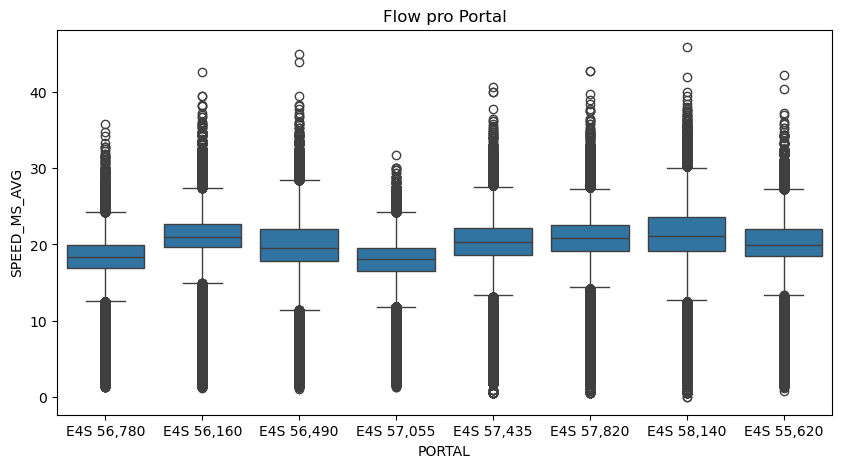

In [56]:

import seaborn as sns

# Boxplot Flow pro Portal
plt.figure(figsize=(10,5))
sns.boxplot(x='PORTAL', y='SPEED_MS_AVG', data=df)
plt.title('Flow pro Portal')
plt.show()


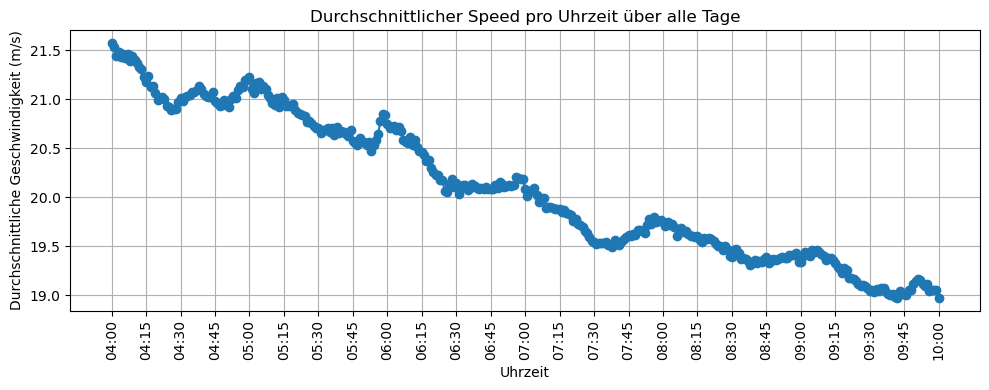

In [98]:
avg_speed = df.groupby('Time_dt')['SPEED_MS_AVG'].mean().reset_index()
#avg_speed['Time_min'] = avg_speed['Time_dt'].apply(lambda t: t.hour*60 + t.minute + t.second/60)
avg_speed['Time_str'] = avg_speed['Time_dt'].apply(lambda t: t.strftime('%H:%M'))

# Plotten
plt.figure(figsize=(10,4))
plt.plot(avg_speed['Time_str'], avg_speed['SPEED_MS_AVG'], marker='o')
plt.xlabel('Uhrzeit')
plt.xticks(avg_speed['Time_str'][::15], rotation=90)  # alle 15 Minuten
plt.ylabel('Durchschnittliche Geschwindigkeit (m/s)')
plt.title('Durchschnittlicher Speed pro Uhrzeit über alle Tage')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: float() argument must be a string or a real number, not 'datetime.time'

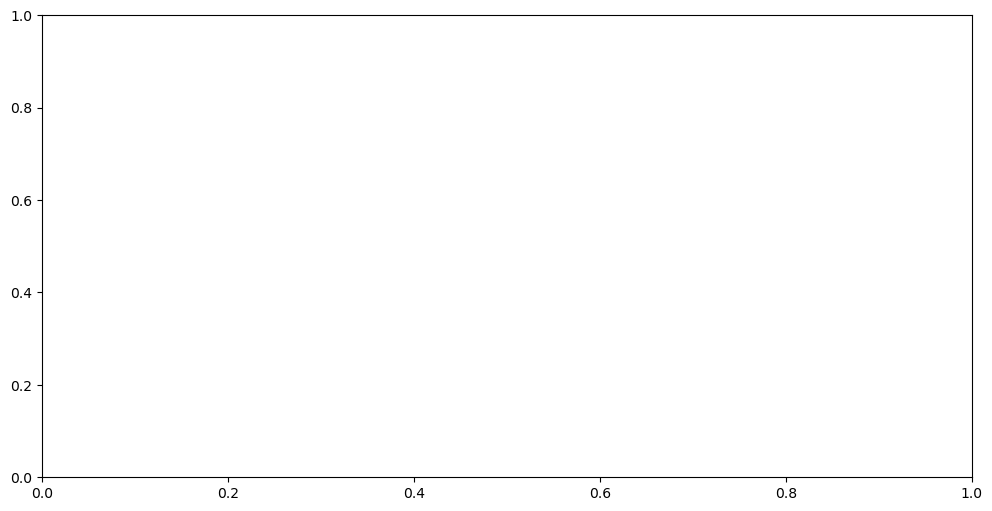

In [124]:
# Schritt 1: Gruppieren nach Sensor & Uhrzeit
avg_speed_sensors = (
    df.groupby(['DP_ID', 'Time_dt'])['SPEED_MS_AVG']
      .mean()
      .reset_index()
)

# Schritt 2: Pivot → jede Spalte = ein Sensor
pivot_df = avg_speed_sensors.pivot(
    index='Time_dt',    # gemeinsame Zeitachse
    columns='DP_ID',    # je Sensor eine Spalte
    values='SPEED_MS_AVG'
)

# Schritt 3: Zeit als String (optional, nur für die Labels)
pivot_df.index = pivot_df.index.strftime('%H:%M')

# Schritt 4: Plotten
plt.figure(figsize=(12,6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], label=f'Sensor {col}')

plt.xlabel('Uhrzeit')
plt.ylabel('Durchschnittliche Geschwindigkeit (m/s)')
plt.title('Durchschnittlicher Speed pro Uhrzeit (über alle Tage) nach Sensor')
plt.xticks(pivot_df.index[::60], rotation=90)  # z.B. jede Stunde
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


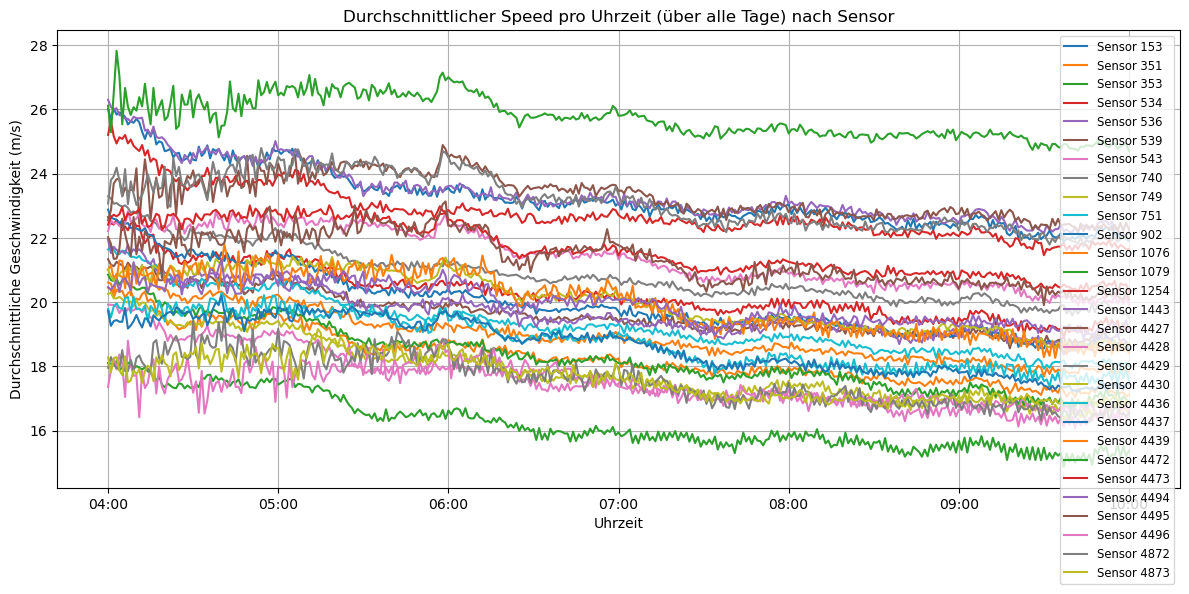

In [126]:


# Schritt 2: Durchschnitt pro Sensor & Uhrzeit
avg_speed_sensors = (
    df.groupby(['DP_ID', 'Time_dt'])['SPEED_MS_AVG']
      .mean()
      .reset_index()
)

# Schritt 3: Dummy-Datum hinzufügen → echte Datetime bauen
avg_speed_sensors['Datetime'] = pd.to_datetime(
    '2000-01-01 ' + avg_speed_sensors['Time_dt'].astype(str)
)

# Schritt 4: Pivot → Zeitachse mit DatetimeIndex
pivot_df = avg_speed_sensors.pivot(
    index='Datetime',
    columns='DP_ID',
    values='SPEED_MS_AVG'
)

# Schritt 5: Plotten
plt.figure(figsize=(12,6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], label=f'Sensor {col}')

plt.xlabel('Uhrzeit')
plt.ylabel('Durchschnittliche Geschwindigkeit (m/s)')
plt.title('Durchschnittlicher Speed pro Uhrzeit (über alle Tage) nach Sensor')

# Formatierung der x-Achse: Uhrzeiten
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))   # jede Stunde
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


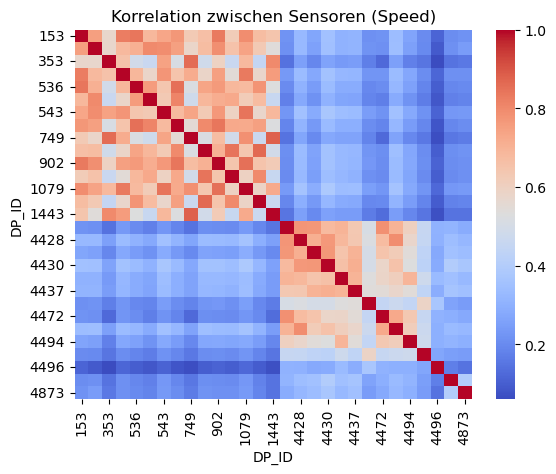

In [128]:
df_corr = df.pivot_table(
    index='Datetime', columns='DP_ID', values='SPEED_MS_AVG'
)
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Korrelation zwischen Sensoren (Speed)')
plt.show()


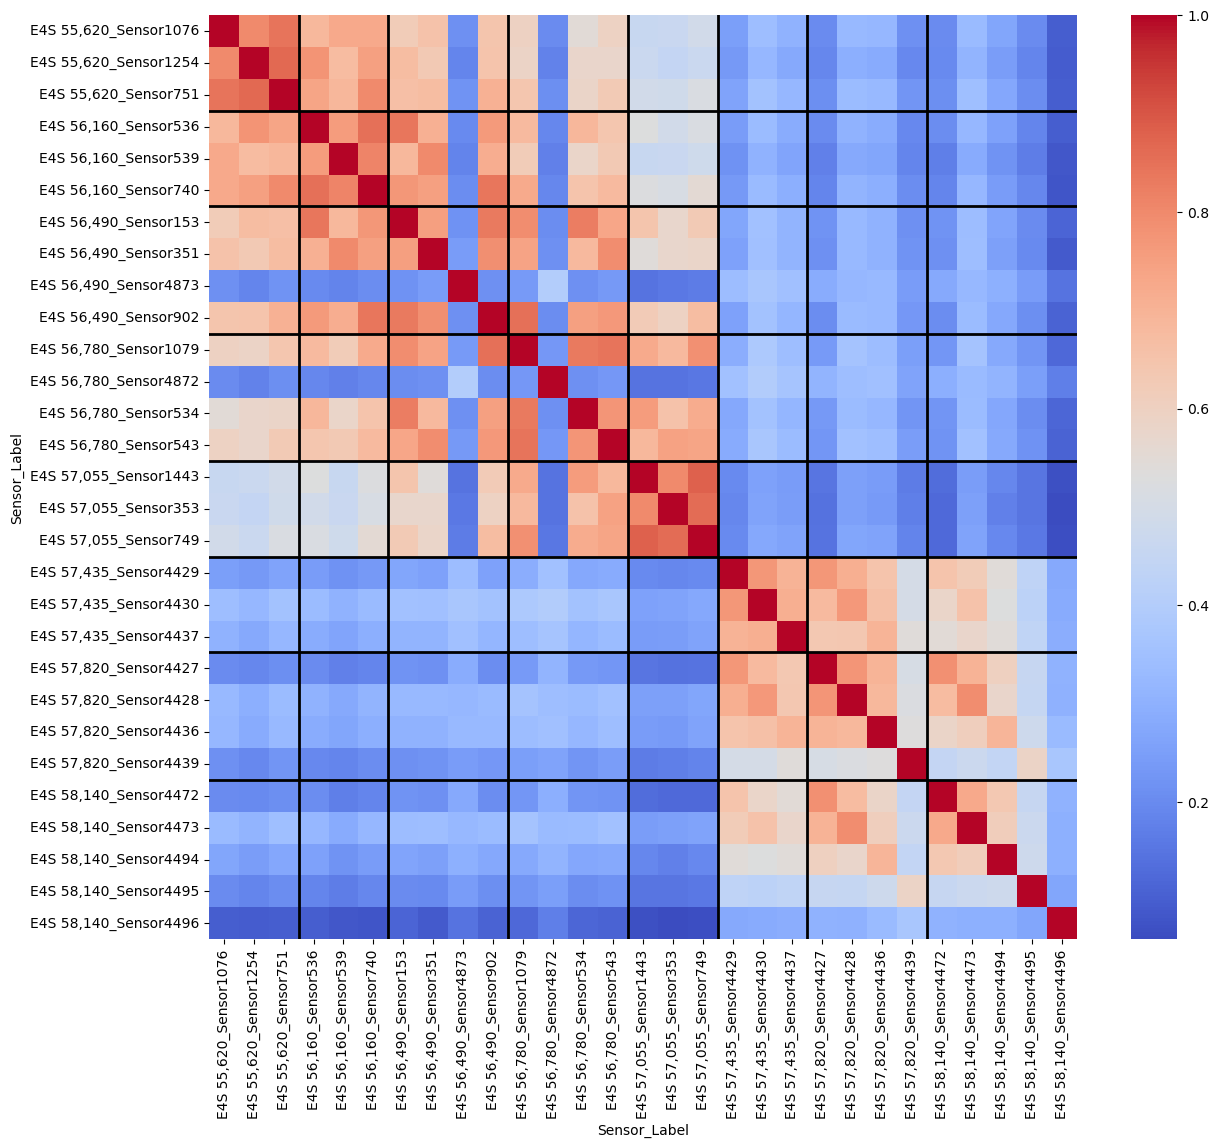

In [134]:
import seaborn as sns

import numpy as np

# 1) Sensor_Label = Portal + Sensor
df['Sensor_Label'] = df['PORTAL'].astype(str) + '_Sensor' + df['DP_ID'].astype(str)

# 2) Pivot-Tabelle
df_corr = df.pivot_table(
    index='Datetime',
    columns='Sensor_Label',
    values='SPEED_MS_AVG'
)

# 3) Sortiere Spalten nach Portal-String lexikographisch
df_corr = df_corr[sorted(df_corr.columns, key=lambda x: x.split('_')[0])]

# 4) Korrelationsmatrix
corr_matrix = df_corr.corr()

# 5) Heatmap plotten
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, cbar=True)

# 6) Fette Linien zwischen Portalen
portal_ids = [x.split('_')[0] for x in df_corr.columns]
unique_portals = sorted(list(set(portal_ids)))

group_indices = []
start_idx = 0
for portal in unique_portals:
    count = portal_ids.count(portal)
    end_idx = start_idx + count
    group_indices.append((start_idx, end_idx))
    start_idx = end_idx

for start, end in group_indices[:-1]:
    plt.axhline(end, color='black', linewidth=2)
    plt.axvline(end, color='black', linewidth=2)


plt.show()


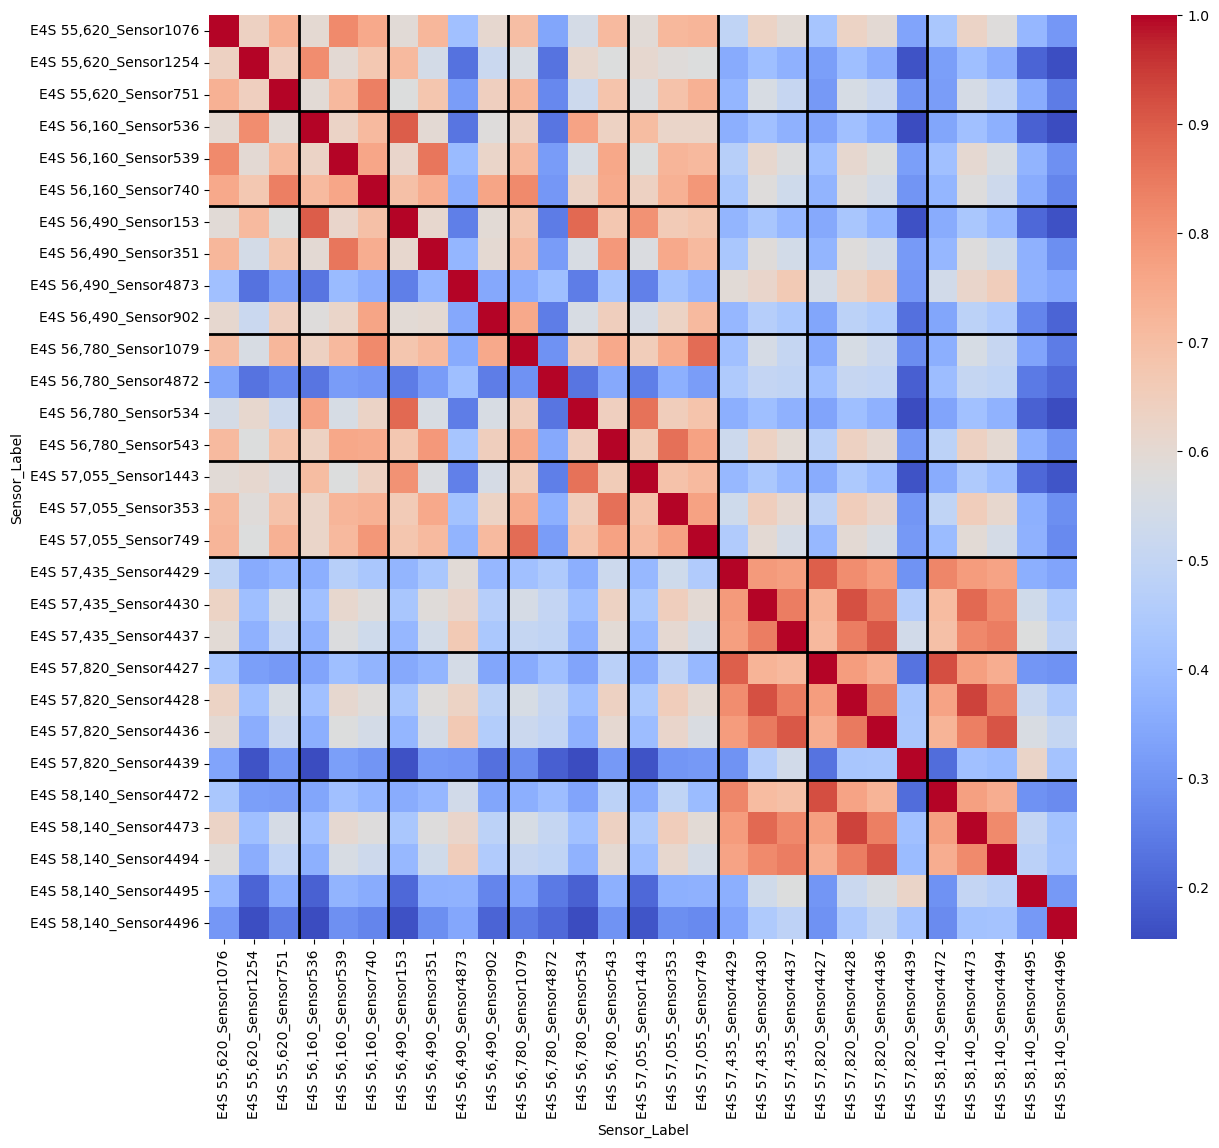

In [138]:

# 2) Pivot-Tabelle
df_corr_2 = df.pivot_table(
    index='Datetime',
    columns='Sensor_Label',
    values='FLOW'
)

# 3) Sortiere Spalten nach Portal-String lexikographisch
df_corr = df_corr_2[sorted(df_corr_2.columns, key=lambda x: x.split('_')[0])]

# 4) Korrelationsmatrix
corr_matrix = df_corr_2.corr()

# 5) Heatmap plotten
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, cbar=True)

# 6) Fette Linien zwischen Portalen
portal_ids = [x.split('_')[0] for x in df_corr_2.columns]
unique_portals = sorted(list(set(portal_ids)))

group_indices = []
start_idx = 0
for portal in unique_portals:
    count = portal_ids.count(portal)
    end_idx = start_idx + count
    group_indices.append((start_idx, end_idx))
    start_idx = end_idx

for start, end in group_indices[:-1]:
    plt.axhline(end, color='black', linewidth=2)
    plt.axvline(end, color='black', linewidth=2)


plt.show()
